[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/home/jisu/Workspaces/Projects/elice/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.4163
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1201
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0146
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0120
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0076
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0052
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0026
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 0.0022
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0022
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0022
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


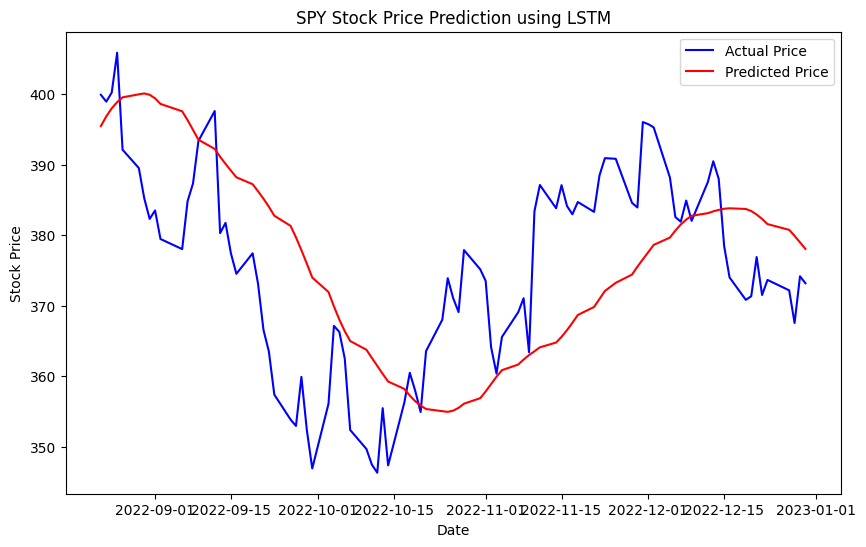

In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# 1. yfinance를 사용해 실제 주가 데이터를 불러옵니다
ticker = 'SPY'  # S&P 500 ETF
start_date = '2020-01-01'
end_date = '2023-01-01'

# 주가 데이터를 가져오기
data = yf.download(ticker, start=start_date, end=end_date)
close_prices = data['Adj Close'].values  # 종가 데이터 사용

# 2. 데이터를 스케일링합니다 (0과 1 사이 값으로 변환)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))

# 3. 학습 데이터와 테스트 데이터를 분리합니다 (80% 학습, 20% 테스트)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# 4. LSTM 모델 학습에 사용할 입력 데이터와 타겟 데이터 생성
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])  # 과거 60일 데이터를 사용
        y.append(data[i + time_step, 0])  # 다음 날의 주가
    return np.array(X), np.array(y)

time_step = 60  # 과거 60일의 데이터를 기반으로 예측

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 데이터 차원 맞추기 (LSTM 입력 형식에 맞게)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 5. LSTM 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64, activation="relu", return_sequences=True, input_shape=(time_step, 1)))
model.add(tf.keras.layers.LSTM(units=64, activation="relu", return_sequences=True))
model.add(tf.keras.layers.LSTM(units=64, activation="relu", return_sequences=False))
model.add(tf.keras.layers.Dense(units=25))
model.add(tf.keras.layers.Dense(units=1))

# 6. 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=64, epochs=10)

# 7. 테스트 데이터로 예측
predicted_prices = model.predict(X_test)

# 8. 원래 스케일로 변환
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 9. 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(data.index[train_size + time_step:], y_test_scaled, color='blue', label='Actual Price')
plt.plot(data.index[train_size + time_step:], predicted_prices, color='red', label='Predicted Price')
plt.title('SPY Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
